Euler-Maruyama:
  Weak Convergence (Expectation Error) Slope: -0.01
  Strong Convergence (L1 Path Error) Slope: 1.01
  Strong Convergence (Max Path Error) Slope: 0.98

Milstein:
  Weak Convergence (Expectation Error) Slope: -0.01
  Strong Convergence (L1 Path Error) Slope: 1.01
  Strong Convergence (Max Path Error) Slope: 0.98


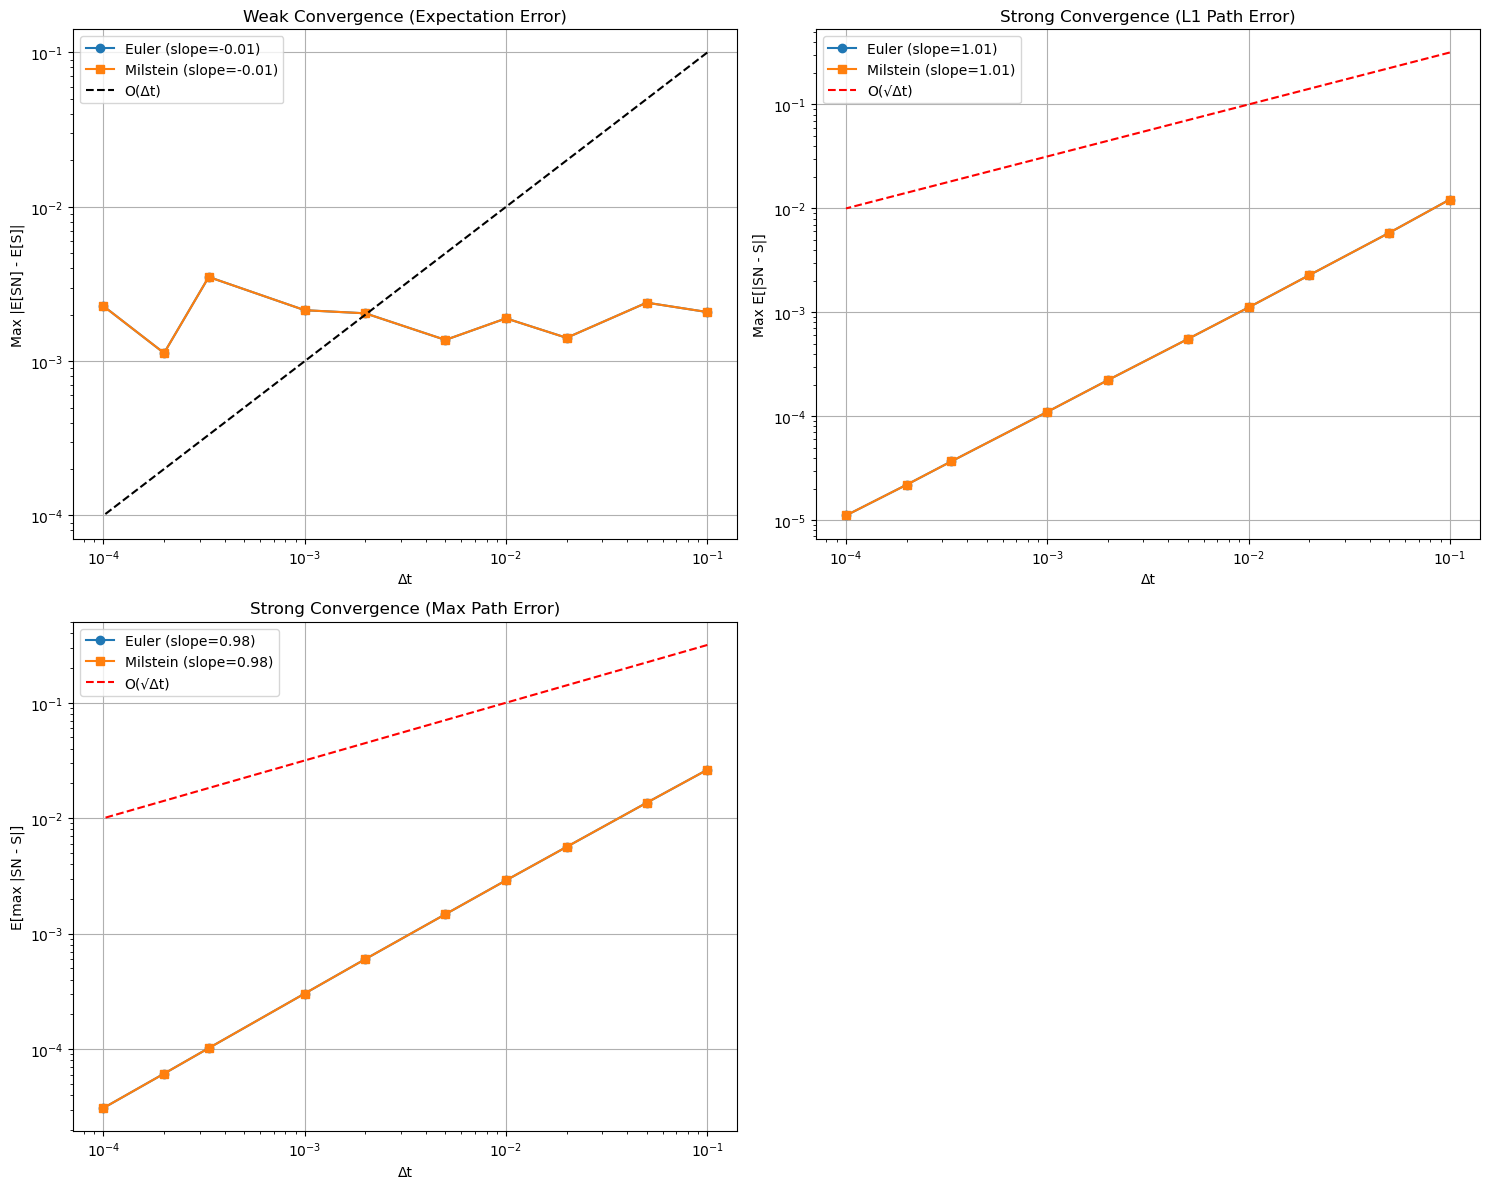

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Vasicek Model
alpha = 3        
r_bar = 0.05     
sigma = 0.25     
r0 = 0.03        
T = 1            
N_vals = [10, 20, 50, 100, 200, 500, 1000, 3000, 5000, 10000]  
M = 10000  # Number of Monte Carlo paths

# Exact expectation function
def exact_expectation(t):
    return r0 * np.exp(-alpha * t) + r_bar * (1 - np.exp(-alpha * t))

# Exact simulation (pathwise) using correlated Brownian increments
def exact_simulation(N, M, Z, Z_indep):
    dt = T / N
    exact_r = np.zeros((M, N + 1))
    exact_r[:, 0] = r0
    
    for i in range(N):
        dt_step = dt
        decay = np.exp(-alpha * dt_step)
        vol_term_exact = sigma * np.sqrt((1 - np.exp(-2 * alpha * dt_step)) / (2 * alpha))
        
        # Compute correlation coefficient rho
        numerator = (1 - np.exp(-alpha * dt_step))
        denominator = alpha * np.sqrt(dt_step * (1 - np.exp(-2 * alpha * dt_step)) / (2 * alpha))
        rho = numerator / denominator
        
        # Generate correlated Brownian increment
        Z_exact = rho * Z[:, i] + np.sqrt(1 - rho**2) * Z_indep[:, i]
        exact_r[:, i+1] = exact_r[:, i] * decay + r_bar * (1 - decay) + vol_term_exact * Z_exact
    
    return exact_r

# Euler-Maruyama simulation
def simulate_euler_maruyama(N, M, Z):
    dt = T / N
    r_em = np.zeros((M, N + 1))
    r_em[:, 0] = r0

    for i in range(N):
        r_em[:, i + 1] = r_em[:, i] + alpha * (r_bar - r_em[:, i]) * dt + sigma * np.sqrt(dt) * Z[:, i]

    return r_em

# Milstein simulation (identical to Euler for Vasicek as σ is constant)
def simulate_milstein(N, M, Z):
    return simulate_euler_maruyama(N, M, Z)

# Error containers for Euler and Milstein
max_abs_diff_exp_em = []
max_abs_diff_exp_mil = []
max_exp_abs_error_em = []
max_exp_abs_error_mil = []
exp_max_abs_error_em = []
exp_max_abs_error_mil = []
dt_values = []

np.random.seed(42)  # Reproducibility

for N in N_vals:
    dt = T / N
    dt_values.append(dt)
    
    # Generate Brownian increments (shared across methods)
    Z = np.random.normal(0, 1, (M, N))
    Z_indep = np.random.normal(0, 1, (M, N))  # For exact simulation
    
    # Simulate all methods
    r_em = simulate_euler_maruyama(N, M, Z)
    r_mil = simulate_milstein(N, M, Z)
    exact_r = exact_simulation(N, M, Z, Z_indep)  # Exact simulation
    
    # Compute exact expectation at grid points
    t_vals = np.linspace(0, T, N + 1)
    E_exact = exact_expectation(t_vals)
    
    # Error 1: max|E[SN] - E[S]|
    max_abs_diff_exp_em.append(np.max(np.abs(np.mean(r_em, axis=0) - E_exact)))
    max_abs_diff_exp_mil.append(np.max(np.abs(np.mean(r_mil, axis=0) - E_exact)))
    
    # Error 2: max E[|SN - S|]
    max_exp_abs_error_em.append(np.max(np.mean(np.abs(r_em - exact_r), axis=0)))
    max_exp_abs_error_mil.append(np.max(np.mean(np.abs(r_mil - exact_r), axis=0)))
    
    # Error 3: E[max|SN - S|]
    exp_max_abs_error_em.append(np.mean(np.max(np.abs(r_em - exact_r), axis=1)))
    exp_max_abs_error_mil.append(np.mean(np.max(np.abs(r_mil - exact_r), axis=1)))

# Convert to numpy arrays
dt_values = np.array(dt_values)
max_abs_diff_exp_em = np.array(max_abs_diff_exp_em)
max_abs_diff_exp_mil = np.array(max_abs_diff_exp_mil)
max_exp_abs_error_em = np.array(max_exp_abs_error_em)
max_exp_abs_error_mil = np.array(max_exp_abs_error_mil)
exp_max_abs_error_em = np.array(exp_max_abs_error_em)
exp_max_abs_error_mil = np.array(exp_max_abs_error_mil)

# Function to compute slope (order of convergence)
def compute_slope(x, y):
    logx = np.log(x)
    logy = np.log(y)
    slope = np.polyfit(logx, logy, 1)[0]
    return slope

# Compute slopes for Euler
slope_weak_em = compute_slope(dt_values, max_abs_diff_exp_em)
slope_strong_em = compute_slope(dt_values, max_exp_abs_error_em)
slope_max_em = compute_slope(dt_values, exp_max_abs_error_em)

# Compute slopes for Milstein
slope_weak_mil = compute_slope(dt_values, max_abs_diff_exp_mil)
slope_strong_mil = compute_slope(dt_values, max_exp_abs_error_mil)
slope_max_mil = compute_slope(dt_values, exp_max_abs_error_mil)

# Print convergence orders
print("Euler-Maruyama:")
print("  Weak Convergence (Expectation Error) Slope:", round(slope_weak_em, 2))
print("  Strong Convergence (L1 Path Error) Slope:", round(slope_strong_em, 2))
print("  Strong Convergence (Max Path Error) Slope:", round(slope_max_em, 2))
print("\nMilstein:")
print("  Weak Convergence (Expectation Error) Slope:", round(slope_weak_mil, 2))
print("  Strong Convergence (L1 Path Error) Slope:", round(slope_strong_mil, 2))
print("  Strong Convergence (Max Path Error) Slope:", round(slope_max_mil, 2))

# ----------------------------
# Log-Log Plots with Slope Annotations
# ----------------------------
plt.figure(figsize=(15, 12))

# Plot 1: Weak convergence (expectation error)
plt.subplot(2, 2, 1)
plt.loglog(dt_values, max_abs_diff_exp_em, 'o-', label=f"Euler (slope={slope_weak_em:.2f})")
plt.loglog(dt_values, max_abs_diff_exp_mil, 's-', label=f"Milstein (slope={slope_weak_mil:.2f})")
plt.loglog(dt_values, dt_values, 'k--', label="O(Δt)")
plt.xlabel("Δt")
plt.ylabel("Max |E[SN] - E[S]|")
plt.title("Weak Convergence (Expectation Error)")
plt.legend()
plt.grid()

# Plot 2: Strong convergence (L1 path error)
plt.subplot(2, 2, 2)
plt.loglog(dt_values, max_exp_abs_error_em, 'o-', label=f"Euler (slope={slope_strong_em:.2f})")
plt.loglog(dt_values, max_exp_abs_error_mil, 's-', label=f"Milstein (slope={slope_strong_mil:.2f})")
plt.loglog(dt_values, dt_values**0.5, 'r--', label="O(√Δt)")
plt.xlabel("Δt")
plt.ylabel("Max E[|SN - S|]")
plt.title("Strong Convergence (L1 Path Error)")
plt.legend()
plt.grid()

# Plot 3: Strong convergence (max path error)
plt.subplot(2, 2, 3)
plt.loglog(dt_values, exp_max_abs_error_em, 'o-', label=f"Euler (slope={slope_max_em:.2f})")
plt.loglog(dt_values, exp_max_abs_error_mil, 's-', label=f"Milstein (slope={slope_max_mil:.2f})")
plt.loglog(dt_values, dt_values**0.5, 'r--', label="O(√Δt)")
plt.xlabel("Δt")
plt.ylabel("E[max |SN - S|]")
plt.title("Strong Convergence (Max Path Error)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [20]:
T = 1
X0 = 0.03       # Initial interest rate
kappa = 2.0     # Mean reversion speed
theta = 0.05    # Long-term mean
sigma = 0.5     # Volatility

dt = 1/365      # Daily time step
N = int(T / dt)
M = 1000       # Number of Monte Carlo simulations

# Initialize the array to store the simulated paths
X = np.zeros((M, N + 1))
X[:, 0] = X0  # set initial value for each path

neg_counts = np.zeros(M, dtype=int)

# Simulate the CIR process using the Euler scheme
for i in range(N):
    dB = np.sqrt(dt) * np.random.normal(0,1,(M,N))
    
    # Compute the next time step:
    sqrt_term = np.sqrt(np.maximum(X[:, i], 0))
    X[:, i + 1] = (1 - kappa * dt) * X[:, i] + kappa * theta * dt + sigma * sqrt_term * dB[:,i]
    
    # Count the negative values
    neg_counts += (X[:, i + 1] < 0)

# Compute the average number of negative occurrences per path
avg_negatives = np.mean(neg_counts)
print("Average number of times per path that X goes negative:", avg_negatives)

Average number of times per path that X goes negative: 3.094


In [21]:
T = 1
X0 = 0.03       
kappa = 2.0     
theta = 0.05    
sigma = 0.5     

dt = 1/365      
N = int(T / dt)
M = 1000       

# Initialize the array to store the simulated paths
X = np.zeros((M, N + 1))
X[:, 0] = X0  # set initial value for each path

neg_counts = np.zeros(M, dtype=int)

# Simulate the CIR process using the Euler scheme
for i in range(N):
    dB = np.sqrt(dt) * np.random.normal(0,1,(M,N))
    
    # Compute the next time step:
    sqrt_term = np.sqrt(np.maximum(X[:, i], 0))
    X[:, i + 1] = (1 - kappa * dt) * X[:, i] + kappa * theta * dt + sigma * sqrt_term * dB[:,i]+0.25*(sigma**2)*((dB[:,i])**2-dt)
    
    # Count the negative values
    neg_counts += (X[:, i + 1] < 0)

# Compute the average number of negative occurrences per path
avg_negatives = np.mean(neg_counts)
print("Average number of times per path that X goes negative:", avg_negatives)

Average number of times per path that X goes negative: 0.0


In [22]:
# Initialize the array to store the simulated paths
T = 1
X0 = 0.03       
kappa = 2.0     
theta = 0.05    
sigma = 0.5     

dt = 1/365     
N = int(T / dt) 
M = 1000       

X = np.zeros((M, N + 1))
X[:, 0] = X0  # set initial value for each path

neg_counts = np.zeros(M, dtype=int)

# Simulate the CIR process using the Euler scheme
for i in range(N):
    dB = np.sqrt(dt) * np.random.normal(0,1,(M,N))
    
    # Compute the next time step:
    sqrt_abs_term = np.sqrt(np.abs(X[:, i]))
    X[:, i + 1] = (1 - kappa * dt) * X[:, i] + kappa * theta * dt + sigma * sqrt_abs_term * dB[:,i]
    
    # Count the negative values
    neg_counts += (X[:, i + 1] < 0)


# Compute the average number of negative occurrences per path
avg_negatives = np.mean(neg_counts)
print("Average number of times per path that X goes negative:", avg_negatives)

# Initialize the array to store the simulated paths
X = np.zeros((M, N + 1))
X[:, 0] = X0  # Set initial value for each path

# Full-Truncation Euler Scheme Simulation
for i in range(N):
    dB = np.sqrt(dt) * np.random.normal(0, 1, M)  # Brownian increments
    sqrt_abs_term = np.sqrt(np.abs(X[:, i]))   # Ensures square root is real
    X[:, i + 1] = X[:, i] + kappa * (theta - np.maximum(X[:, i], 0)) * dt + sigma * sqrt_abs_term * dB

# Ensure non-negativity by truncating negative values to zero
X = np.maximum(X, 0)

# Compute the average number of negative occurrences per path
neg_counts = np.sum(X < 0, axis=1)
avg_negatives = np.mean(neg_counts)
print("Average number of times per path that X goes negative:", avg_negatives)

Average number of times per path that X goes negative: 3.48
Average number of times per path that X goes negative: 0.0


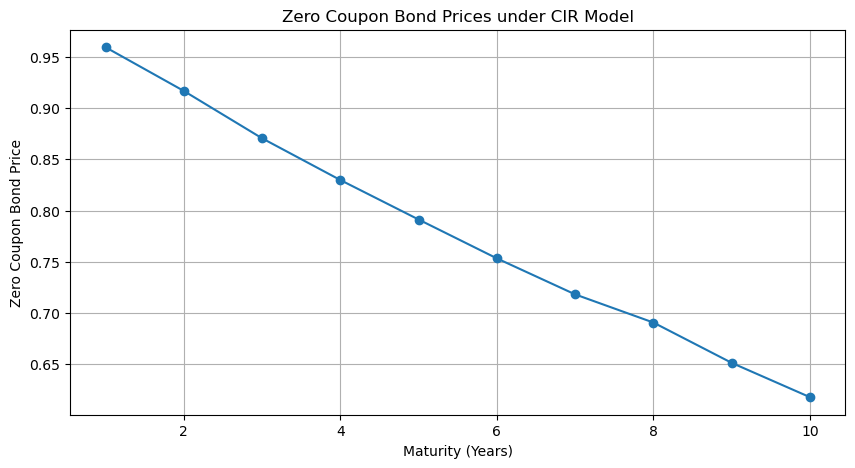

ZCB Price for T=1: 0.9594
ZCB Price for T=2: 0.9168
ZCB Price for T=3: 0.8705
ZCB Price for T=4: 0.8298
ZCB Price for T=5: 0.7912
ZCB Price for T=6: 0.7532
ZCB Price for T=7: 0.7181
ZCB Price for T=8: 0.6906
ZCB Price for T=9: 0.6512
ZCB Price for T=10: 0.6177


In [23]:
# CIR model parameters
X0 = 0.03       # Initial interest rate
kappa = 2.0     # Mean reversion speed
theta = 0.05    # Long-term mean
sigma = 0.5     # Volatility
dt = 1/365      # Daily time step
M = 1000       # Number of Monte Carlo simulations
T_max = 10      # Maximum maturity (years)
T_values = np.arange(1, T_max + 1)  # Bond maturities from 1 to 10 years

# Storage for Zero Coupon Bond prices
ZCB_prices = []

# Simulate CIR process and compute ZCB prices
for T in T_values:
    N = int(T / dt)  # Number of time steps
    X = np.zeros((M, N + 1))
    X[:, 0] = X0
    
    # Monte Carlo simulation of the CIR process
    for i in range(N):
        dB = np.sqrt(dt) * np.random.normal(0, 1, M)  # Brownian increments
        sqrt_term = np.sqrt(np.maximum(X[:, i], 0))  # Ensures square root is real
        X[:, i + 1] = X[:, i] + kappa * (theta - np.maximum(X[:, i], 0)) * dt + sigma * sqrt_term * dB
    
    # Approximate integral ∫ X_s ds using trapezoidal rule
    X_avg = 0.5 * (X[:, :-1] + X[:, 1:])  # Average of consecutive points
    integral_X = np.sum(X_avg * dt, axis=1)  # Discrete sum approximation
    
    # Compute expected discount factor
    ZCB_price = np.mean(np.exp(-integral_X))
    ZCB_prices.append(ZCB_price)

# Plot the term structure
plt.figure(figsize=(10, 5))
plt.plot(T_values, ZCB_prices, marker='o', linestyle='-')
plt.xlabel("Maturity (Years)")
plt.ylabel("Zero Coupon Bond Price")
plt.title("Zero Coupon Bond Prices under CIR Model")
plt.grid(True)
plt.show()

# Print bond prices
for t, p in zip(T_values, ZCB_prices):
    print(f"ZCB Price for T={t}: {p:.4f}")


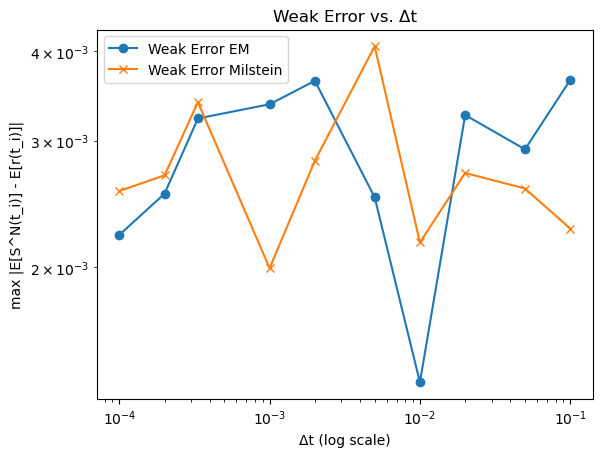

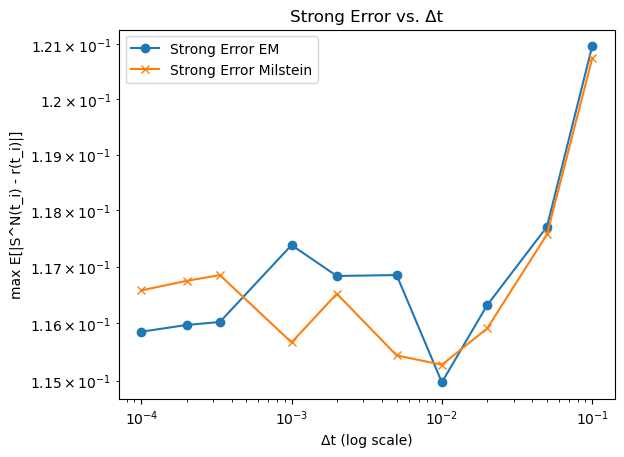

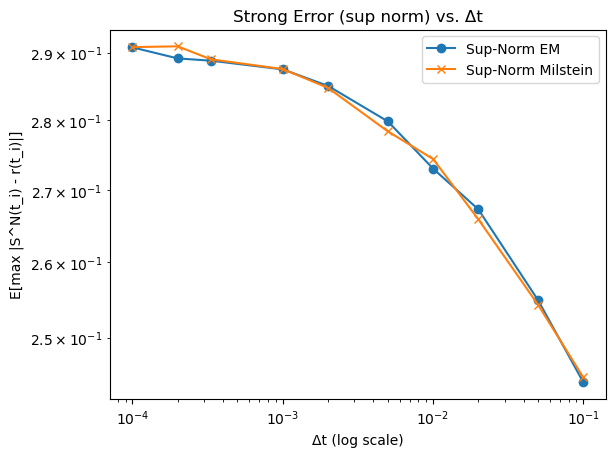


=== RESULTS ( tabular ) ===
    N         dt        Weak_EM       Weak_Mil         Str_EM        Str_Mil         Sup_EM        Sup_Mil
   10    0.10000     3.6438e-03     2.2620e-03     1.2097e-01     1.2074e-01     2.4426e-01     2.4487e-01
   20    0.05000     2.9168e-03     2.5723e-03     1.1771e-01     1.1757e-01     2.5493e-01     2.5432e-01
   50    0.02000     3.2563e-03     2.7035e-03     1.1632e-01     1.1591e-01     2.6729e-01     2.6592e-01
  100    0.01000     1.3810e-03     2.1632e-03     1.1497e-01     1.1528e-01     2.7302e-01     2.7439e-01
  200    0.00500     2.5006e-03     4.0596e-03     1.1685e-01     1.1544e-01     2.7982e-01     2.7837e-01
  500    0.00200     3.6343e-03     2.8120e-03     1.1684e-01     1.1652e-01     2.8504e-01     2.8475e-01
 1000    0.00100     3.3706e-03     1.9918e-03     1.1738e-01     1.1567e-01     2.8751e-01     2.8755e-01
 3000    0.00033     3.2207e-03     3.3933e-03     1.1603e-01     1.1685e-01     2.8881e-01     2.8901e-01
 5000   

In [40]:
def vasicek_exact_sim(r0, alpha, rbar, sigma, T, N, M, rng=None):
    """
    Exact (Ornstein–Uhlenbeck) simulation at discrete times t_i = i*(T/N).
    """
    dt = T / N
    if rng is None:
        rng = np.random.default_rng()

    rExact = np.zeros((M, N+1))
    rExact[:, 0] = r0

    exp_adt = np.exp(-alpha*dt)
    var_step = (sigma**2 / (2*alpha))*(1 - np.exp(-2*alpha*dt))

    for i in range(N):
        mean_i = rExact[:, i]*exp_adt + rbar*(1 - exp_adt)
        Z = rng.normal(loc=0.0, scale=1.0, size=M)
        rExact[:, i+1] = mean_i + np.sqrt(var_step)*Z

    return rExact

def vasicek_euler_maruyama(r0, alpha, rbar, sigma, T, N, M, rng=None):
    """
    Euler–Maruyama scheme for the Vasicek model.
    """
    dt = T / N
    if rng is None:
        rng = np.random.default_rng()

    rEM = np.zeros((M, N+1))
    rEM[:, 0] = r0

    for i in range(N):
        Z = rng.normal(loc=0.0, scale=1.0, size=M)
        rEM[:, i+1] = rEM[:, i] + alpha*(rbar - rEM[:, i])*dt + sigma*np.sqrt(dt)*Z

    return rEM

def vasicek_milstein(r0, alpha, rbar, sigma, T, N, M, rng=None):
    """
    Milstein scheme for the Vasicek model. Here, Milstein = EM because sigma is constant.
    """
    dt = T / N
    if rng is None:
        rng = np.random.default_rng()

    rMil = np.zeros((M, N+1))
    rMil[:, 0] = r0

    for i in range(N):
        Z = rng.normal(loc=0.0, scale=1.0, size=M)
        rMil[:, i+1] = rMil[:, i] + alpha*(rbar - rMil[:, i])*dt + sigma*np.sqrt(dt)*Z

    return rMil

def problem5_vasicek():
    # --- Parameters ---
    alpha = 3.0
    rbar  = 0.05
    sigma = 0.25
    r0    = 0.03
    T     = 1.0

    M = 10000  # number of paths
    N_values = [10, 20, 50, 100, 200, 500, 1000, 3000, 5000, 10000] 

    err_weak_EM   = np.zeros(len(N_values))
    err_strong_EM = np.zeros(len(N_values))
    err_sup_EM    = np.zeros(len(N_values))

    err_weak_Mil   = np.zeros(len(N_values))
    err_strong_Mil = np.zeros(len(N_values))
    err_sup_Mil    = np.zeros(len(N_values))

    rng = np.random.default_rng(seed=12345)

    for k, N in enumerate(N_values):
        # 1) Exact
        rExact = vasicek_exact_sim(r0, alpha, rbar, sigma, T, N, M, rng=rng)
        # 2) Euler–Maruyama
        rEM = vasicek_euler_maruyama(r0, alpha, rbar, sigma, T, N, M, rng=rng)
        # 3) Milstein
        rMil = vasicek_milstein(r0, alpha, rbar, sigma, T, N, M, rng=rng)

        # 4) Errors
        mean_exact = np.mean(rExact, axis=0)
        mean_EM    = np.mean(rEM, axis=0)
        mean_Mil   = np.mean(rMil, axis=0)

        # (A) Weak error
        err_weak_EM[k]  = np.max(np.abs(mean_EM  - mean_exact))
        err_weak_Mil[k] = np.max(np.abs(mean_Mil - mean_exact))

        # (B) Strong error: max_{t_i} E[|S^N(t_i) - r(t_i)|]
        abs_diff_EM  = np.mean(np.abs(rEM  - rExact), axis=0)
        abs_diff_Mil = np.mean(np.abs(rMil - rExact), axis=0)

        err_strong_EM[k]  = np.max(abs_diff_EM)
        err_strong_Mil[k] = np.max(abs_diff_Mil)

        # (C) Strong error, sup norm: E[max_{t_i} |S^N(t_i) - r(t_i)|]
        sup_diff_EM  = np.max(np.abs(rEM  - rExact), axis=1)
        sup_diff_Mil = np.max(np.abs(rMil - rExact), axis=1)

        err_sup_EM[k]  = np.mean(sup_diff_EM)
        err_sup_Mil[k] = np.mean(sup_diff_Mil)

    dtvals = [T/N for N in N_values]

    # --- Plotting (simplified math) ---
    plt.figure()
    plt.loglog(dtvals, err_weak_EM, 'o-', label='Weak Error EM')
    plt.loglog(dtvals, err_weak_Mil, 'x-', label='Weak Error Milstein')
    plt.xlabel('Δt (log scale)')
    plt.ylabel('max |E[S^N(t_i)] - E[r(t_i)]|')
    plt.title('Weak Error vs. Δt')
    plt.legend()
    plt.show()

    plt.figure()
    plt.loglog(dtvals, err_strong_EM, 'o-', label='Strong Error EM')
    plt.loglog(dtvals, err_strong_Mil, 'x-', label='Strong Error Milstein')
    plt.xlabel('Δt (log scale)')
    plt.ylabel('max E[|S^N(t_i) - r(t_i)|]')
    plt.title('Strong Error vs. Δt')
    plt.legend()
    plt.show()

    plt.figure()
    plt.loglog(dtvals, err_sup_EM, 'o-', label='Sup-Norm EM')
    plt.loglog(dtvals, err_sup_Mil, 'x-', label='Sup-Norm Milstein')
    plt.xlabel('Δt (log scale)')
    plt.ylabel('E[max |S^N(t_i) - r(t_i)|]')
    plt.title('Strong Error (sup norm) vs. Δt')
    plt.legend()
    plt.show()

    # Optional: print a small table
    print("\n=== RESULTS ( tabular ) ===")
    print(f"{'N':>5}   {'dt':>8}   {'Weak_EM':>12}   {'Weak_Mil':>12}   "
          f"{'Str_EM':>12}   {'Str_Mil':>12}   {'Sup_EM':>12}   {'Sup_Mil':>12}")
    for k, N in enumerate(N_values):
        print(f"{N:5d}   {dtvals[k]:8.5f}   "
              f"{err_weak_EM[k]:12.4e}   {err_weak_Mil[k]:12.4e}   "
              f"{err_strong_EM[k]:12.4e}   {err_strong_Mil[k]:12.4e}   "
              f"{err_sup_EM[k]:12.4e}   {err_sup_Mil[k]:12.4e}")

if __name__ == "__main__":
    problem5_vasicek()
